In [1]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, ConcatDataset

import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import random

In [2]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
from segmentation_models_pytorch.utils.metrics import IoU, Fscore, Accuracy

In [3]:
import matplotlib.pyplot as plt

# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image, 'gray')
    plt.show()

# Settings

In [4]:
root = os.getcwd()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

BATCH = 8
GEN_IN_CHANNELS = 1
GEN_N_CLASSES = 1
DIS_IN_CHANNELS = 1
DIS_N_CLASSES = 3
EPOCH =100

### Model Settings

#### encoder

In [5]:
ENCODER = "resnet152"
ENCODER_WEIGHT = None

#### decoder

In [6]:
DECODER_ATT = "scse"

#### head

In [7]:
GEN_ACT = "sigmoid"
DIS_ACT = "softmax"

### Optimizer Settings

In [8]:
GEN_OPTIM_NAME = "adam"
GEN_init_lr = 1e-4
GEN_momentum = 0.9

In [9]:
DIS_OPTIM_NAME = "adam"
DIS_init_lr = 3e-4
DIS_momentum = 0.9

# Epochs

In [10]:
from codes.losses import SSIMLoss
from codes.losses import MAELoss
from pytorch_msssim import ssim
from codes.metrics import PSNR, SNR
from codes.activation import Activation
from codes.utils import hu_clip_tensor

In [11]:
def train_a2b_epoch(generator, gen_optimizer, discriminator, dis_optimizer, dataloader, device):
  
    # change mode to train and move to current device
    generator = generator.train().to(device)
    discriminator = discriminator.train().to(device)

    dis_l = 0
    gen_l = 0
    ssim_l = 0
    mae_l = 0
    air_l = 0
    bone_l = 0
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, air_y, bone_x, bone_y = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = generator(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
        y_cls = discriminator(y)
        y_pr_cls = discriminator(y_pr)
        x_cls = discriminator(x)
        
        # adversarial loss
        _gen = nn.CrossEntropyLoss()(y_pr_cls.float(), torch.ones(y_pr_cls.size()[0], dtype=torch.long, device=device))
        _dis = nn.CrossEntropyLoss()(y_cls.float(), torch.ones(y_cls.size()[0], dtype=torch.long, device=device)) + \
                                nn.CrossEntropyLoss()(x_cls.float(), torch.zeros(x_cls.size()[0], dtype=torch.long, device=device)) + \
                                nn.CrossEntropyLoss()(y_pr_cls.float(), 2 * torch.ones(y_pr_cls.size()[0], dtype=torch.long, device=device) )
        # main loss
        _mae = MAELoss()(y_pr.float(), y.float())
        _ssim =SSIMLoss()(y_pr, y, data_range=1.0, size_average=True) # return (N,)
        
        # auxilary loss
        upper = ((-256) - (-500))/(500-(-500))
        lower = ((-257) - (-500))/(500-(-500))
        air_pr = hu_clip_tensor(y_pr.double(), upper, lower, True)
        air_loss = nn.BCELoss()(air_pr.float(), air_x.float())
        
        upper = ((256) - (-500))/(500-(-500))
        lower = ((255) - (-500))/(500-(-500))
        bone_pr = hu_clip_tensor(y_pr.double(), upper, lower, True)
        bone_loss = nn.BCELoss()(bone_pr.float(), bone_x.float())

        _loss = _gen + _dis + _mae + _ssim + air_loss + bone_loss
                        
        gen_optimizer.zero_grad()
        dis_optimizer.zero_grad()
        _loss.backward()
        
        gen_optimizer.step()
        dis_optimizer.step()

        dis_l += _gen.item()
        gen_l += _dis.item()
        air_l += air_loss.item()
        bone_l += bone_loss.item()
        ssim_l += _ssim.item()
        mae_l += _mae.item()

    return  mae_l/(index+1), ssim_l/(index+1), air_l/(index+1), bone_l/(index+1), gen_l/(index+1), dis_l/(index+1)

In [12]:
@torch.no_grad()
def eval_epoch(generator, discriminator, dataloader, device):
  
    # change mode to train and move to current device
    generator = generator.eval().to(device)
    discriminator = discriminator.eval().to(device)

    ssim_ = []
    psnr_ = []
    mae_ = []
    snr_ = []
    air_ = []
    bone_ = []
    acc_ = []
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, air_y, bone_x, bone_y = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = generator(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
        y_cls = discriminator(y)
        y_cls = Activation(name=DIS_ACT)(y_cls)
        y_pr_cls = discriminator(y_pr)
        y_pr_cls = Activation(name=DIS_ACT)(y_pr_cls)
        x_cls = discriminator(x)
        x_cls = Activation(name=DIS_ACT)(x_cls)
        
        # main
        _ssim = ssim(y, y_pr, data_range=1.0, size_average=True) # return (N,)
        _psnr = PSNR()(y_pr, y, 1.0)
        _snr = SNR()(y_pr, y)
        _mae = MAELoss()(y_pr.float(), y.float())

        ssim_ += [_ssim.item()]
        psnr_ += [_psnr.item()]
        mae_ += [_mae.item()]
        snr_ += [_snr.item()]
        
        # auxilary
        upper = ((-256) - (-500))/(500-(-500))
        lower = ((-257) - (-500))/(500-(-500))
        air_pr = hu_clip_tensor(y_pr.double(), upper, lower, True)
        dice = Fscore()(air_pr, air_x)
        air_ += [dice.item()]
        
        upper = ((256) - (-500))/(500-(-500))
        lower = ((255) - (-500))/(500-(-500))
        bone_pr = hu_clip_tensor(y_pr.double(), upper, lower, True)
        dice = Fscore()(bone_pr, bone_x)
        bone_ += [dice.item()]
        
        # adversarial
        total = x.size()[0]
        _, predicted = torch.max(y_cls.data, 1)
        correct = (predicted == torch.ones(total, dtype=torch.long, device=predicted.device)).sum().item()
        acc_ += [correct / total]
        _, predicted = torch.max(y_pr_cls.data, 1)
        correct = (predicted == 2 * torch.ones(total, dtype=torch.long, device=predicted.device)).sum().item()
        acc_ += [correct / total]
        _, predicted = torch.max(x_cls.data, 1)
        correct = (predicted == torch.zeros(total, dtype=torch.long, device=predicted.device)).sum().item()
        acc_ += [correct / total]

    return  sum(ssim_)/len(ssim_), sum(psnr_)/len(psnr_), sum(snr_)/len(snr_), sum(mae_)/len(mae_), \
                    sum(air_)/len(air_), sum(bone_)/len(bone_), sum(acc_)/len(acc_)

In [33]:
@torch.no_grad()
def test_epoch(model, dataloader, device, save=False, path=None):
  
    # change mode to train and move to current device
    model = model.eval().to(device)

    iid = 0
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, air_y, bone_x, bone_y = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = model(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
        upper = ((-256) - (-500))/(500-(-500))
        lower = ((-257) - (-500))/(500-(-500))
        air_pr = hu_clip_tensor(y_pr.double(), upper, lower, True)
        
        upper = ((256) - (-500))/(500-(-500))
        lower = ((255) - (-500))/(500-(-500))
        bone_pr = hu_clip_tensor(y_pr.double(), upper, lower, True)

        for b in range(x.shape[0]):
            
            tmp_y = y[b, :, :, :].unsqueeze(0)
            tmp_y_pr = y_pr[b, :, :, :].unsqueeze(0)
            tmp_air = air_x[b, :, :, :].unsqueeze(0)
            tmp_air_pr = air_pr[b, :, :, :].unsqueeze(0)
            tmp_bone = bone_x[b, :, :, :].unsqueeze(0)
            tmp_bone_pr = bone_pr[b, :, :, :].unsqueeze(0)
            
            _ssim = ssim(tmp_y, tmp_y_pr, data_range=1.0, size_average=True) # return (N,)
            _psnr = PSNR()(tmp_y_pr, tmp_y, 1.0)
            _snr = SNR()(tmp_y_pr, tmp_y)
            _mae = MAELoss()(tmp_y_pr.float(), tmp_y.float())
            _air = Fscore()(tmp_air_pr, tmp_air)
            _bone = Fscore()(tmp_bone_pr, tmp_bone)
            
            print("ssim score = {}".format(_ssim.item()))
            print("psnr score = {}".format(_psnr.item()))
            print("snr score = {}".format(_snr.item()))
            print("mae error = {}".format(_mae.item()))
            print("air dice score = {}".format(_air.item()))
            print("bone dice score = {}".format(_bone.item()))
            
            __cbct = (x.squeeze().cpu().numpy()[b, :, :] * 255).astype(np.uint8)
            __ct = (tmp_y.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct_pred = (tmp_y_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __air = (tmp_air.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __air_pr = (tmp_air_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __bone = (tmp_bone.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __bone_pr = (tmp_bone_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            
            visualize(
                cbct = __cbct,
                ct_y = __ct,
                ct_pred = __ct_pred,
                air = __air,
                air_pr = __air_pr,
                bone = __bone,
                bone_pr = __bone_pr
            )
            
            if save:
                path_dir = os.path.join(path, "file_{}".format(iid))
                try:
                    os.mkdir(path_dir)
                except FileExistsError:
                    pass
                
                cv2.imwrite(os.path.join(path_dir, "cbct.jpg"), __cbct)
                cv2.imwrite(os.path.join(path_dir, "ct.jpg"), __ct)
                cv2.imwrite(os.path.join(path_dir, "ct_pred.jpg"), __ct_pred)
                cv2.imwrite(os.path.join(path_dir, "air.jpg"), __air)
                cv2.imwrite(os.path.join(path_dir, "air_pred.jpg"), __air_pr)
                cv2.imwrite(os.path.join(path_dir, "bone.jpg"), __bone)
                cv2.imwrite(os.path.join(path_dir, "bone_pred.jpg"), __bone_pr)
                
            iid += 1

# Discriminator

In [14]:
class Discriminator(nn.Module):
    def __init__(self, encoder, hidden_ch=2048, n_classes=2, activation=None):
        
        super(Discriminator, self).__init__()
        
        self.encoder = encoder
        self.classifier = nn.Linear(in_features=hidden_ch, out_features=n_classes)
        self.pooling = nn.AdaptiveAvgPool2d(1)
        self.activation = Activation(name=activation)
        
        
    def forward(self, x):
        
        x = self.encoder(x)[-1]
        x = self.pooling(x)
        x = torch.flatten(x, start_dim=1)
        x = self.classifier(x)
        
        return self.activation(x)

# Read Data

In [15]:
from codes.dataset import Dataset
import codes.augmentation as aug

In [16]:
train_case_path = 'data/train/*_*'
test_case_path = 'data/test/*_*'

In [17]:
trainset = Dataset(path=train_case_path, intensity_aug=aug.training_intensity_augmentation(), geometry_aug=aug.get_training_augmentation())
testset = Dataset(test_case_path, intensity_aug=aug.validation_intensity_augmentation(), geometry_aug=aug.get_validation_augmentation())

In [18]:
len(trainset), len(testset)

(1344, 191)

In [19]:
x, y, *_ = trainset[20]

(<matplotlib.image.AxesImage at 0x7f751db15fd0>,)

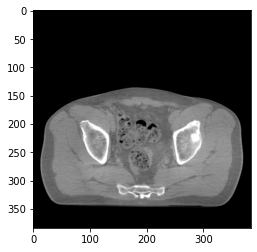

In [20]:
plt.imshow(x.squeeze(), 'gray'),

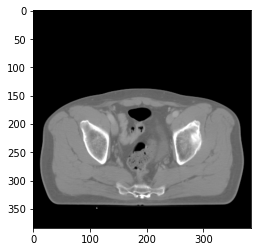

In [21]:
plt.imshow(y.squeeze(), 'gray')

In [22]:
x.shape, y.shape

((1, 384, 384), (1, 384, 384))

# training

In [23]:
import wandb

wandb.init(project="cbct_gan", config={
    "data": {
        "batchsize": BATCH,
    },
    "epochs": EPOCH,
    "model": {
        "in_channels": GEN_IN_CHANNELS,
        "out_channels": GEN_N_CLASSES,
        "optimizer": GEN_OPTIM_NAME,
        "init_lr": GEN_init_lr,
        "momentum": GEN_momentum,
        "encoder": ENCODER,
        "encoder_weight": ENCODER_WEIGHT,
        "activation": GEN_ACT,
        "decoder_attention_type": DECODER_ATT
    },
    "discriminator": {
        "in_channels": DIS_IN_CHANNELS,
        "out_channels": DIS_N_CLASSES,
        "optimizer": DIS_OPTIM_NAME,
        "init_lr": DIS_init_lr,
        "momentum": DIS_momentum,
        "encoder": "resnet152"
    }
})

wandb: Currently logged in as: junjun (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.9 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [24]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH, shuffle=True, num_workers=8)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH, shuffle=False, num_workers=4)

In [25]:
import segmentation_models_pytorch as smp
import torchvision.models as models

model = smp.Unet(encoder_name=ENCODER, encoder_weights=ENCODER_WEIGHT, in_channels=GEN_IN_CHANNELS, classes=GEN_N_CLASSES)

In [26]:
discriminator = smp.Unet(encoder_name=ENCODER, encoder_weights=ENCODER_WEIGHT, in_channels=DIS_IN_CHANNELS, classes=DIS_N_CLASSES)
discriminator = Discriminator(encoder=discriminator.encoder, hidden_ch=2048, n_classes=DIS_N_CLASSES, activation=DIS_ACT)

In [27]:
from codes.optimizer import Optimizer
# optimizer = optim.SGD(model.parameters(), lr=init_lr, momentum=momentum)
gen_optimizer = Optimizer(model.parameters(), name=GEN_OPTIM_NAME, lr=GEN_init_lr)
dis_optimizer = Optimizer(discriminator.parameters(), name=DIS_OPTIM_NAME, lr=DIS_init_lr)

In [28]:
wandb.watch(model)
wandb.watch(discriminator)

min_mae = 99999

for epoch in range(EPOCH):
        
        loss_mae, loss_ssim, loss_air, loss_bone, loss_gen, loss_dis = train_a2b_epoch(model, gen_optimizer, discriminator, dis_optimizer, trainloader, device)
        score_ssim_train, score_psnr_train, score_snr_train, score_mae_train, score_air_train, score_bone_train, score_acc_train = eval_epoch(model, discriminator, trainloader, device)
        score_ssim_test, score_psnr_test, score_snr_test, score_mae_test, score_air_test, score_bone_test, score_acc_test = eval_epoch(model, discriminator, testloader, device)

        
        wandb.log({
            "loss ssim": loss_ssim,
            "loss mae": loss_mae,
            "loss mask": loss_air,
            "loss bone": loss_bone,
            "loss gen": loss_gen,
            "loss dis": loss_dis,
            "trainset ssim score": score_ssim_train,
            "trainset psnr score": score_psnr_train,
            "trainset mae error": score_mae_train,
            "trainset snr score": score_snr_train,
            "trainset mask score": score_air_train,
            "trainset bone score": score_bone_train,
            "trainset acc score": score_acc_train,
            "testset mae error": score_mae_test,
            "testset ssim score": score_ssim_test,
            "testset psnr score": score_psnr_test,
            "testset snr score": score_snr_test,
            "testset mask score": score_air_test,
            "testset bone score": score_bone_test,
            "testset acc score": score_acc_test
        })
        
        
        if score_mae_test < min_mae:
            min_mae = score_mae_test
            checkpoint = {
                "model": model.state_dict(),
                "optimizer": gen_optimizer.state_dict(),
                "dicriminator": discriminator.state_dict(),
                "dis_optim": dis_optimizer.state_dict()
            }
            torch.save(checkpoint, os.path.join("{}.pth".format(wandb.run.name)))

168it [02:39,  1.05it/s]
168it [00:47,  3.52it/s]
24it [00:07,  3.37it/s]
168it [02:40,  1.05it/s]
168it [00:47,  3.50it/s]
24it [00:07,  3.36it/s]
168it [02:40,  1.05it/s]
168it [00:48,  3.50it/s]
24it [00:07,  3.36it/s]
168it [02:41,  1.04it/s]
168it [00:48,  3.50it/s]
24it [00:07,  3.36it/s]
168it [02:40,  1.04it/s]
168it [00:48,  3.50it/s]
24it [00:07,  3.35it/s]
168it [02:41,  1.04it/s]
168it [00:48,  3.50it/s]
24it [00:07,  3.36it/s]
168it [02:41,  1.04it/s]
168it [00:48,  3.49it/s]
24it [00:07,  3.36it/s]
168it [02:41,  1.04it/s]
168it [00:48,  3.50it/s]
24it [00:07,  3.36it/s]
168it [02:41,  1.04it/s]
168it [00:48,  3.50it/s]
24it [00:07,  3.37it/s]
168it [02:41,  1.04it/s]
168it [00:48,  3.49it/s]
24it [00:07,  3.36it/s]
168it [02:41,  1.04it/s]
168it [00:48,  3.50it/s]
24it [00:07,  3.35it/s]
168it [02:41,  1.04it/s]
168it [00:48,  3.50it/s]
24it [00:07,  3.35it/s]
168it [02:41,  1.04it/s]
168it [00:48,  3.49it/s]
24it [00:07,  3.35it/s]
168it [02:40,  1.04it/s]
168it [00:48,

In [29]:
checkpoint = torch.load(os.path.join("{}.pth".format(wandb.run.name)))

In [30]:
model = smp.Unet(encoder_name=ENCODER, encoder_weights=ENCODER_WEIGHT, in_channels=GEN_IN_CHANNELS, classes=GEN_N_CLASSES)
model.load_state_dict(checkpoint["model"])

<All keys matched successfully>

In [31]:
os.mkdir(os.path.join("eval-gan", wandb.run.name))

0it [00:00, ?it/s]

ssim score = 0.8930560350418091
psnr score = 25.80716896057129
snr score = 15.870105743408203
mae error = 0.017041398212313652
air dice score = 0.9986013706567578
bone dice score = 0.9527108433742062


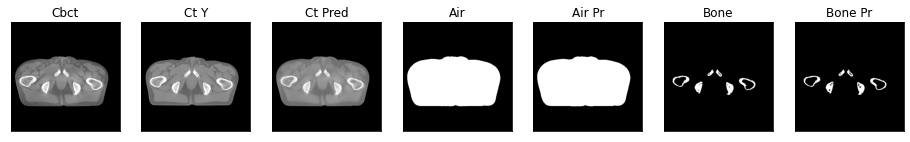

ssim score = 0.8927512764930725
psnr score = 25.68746566772461
snr score = 15.797938346862793
mae error = 0.017318790778517723
air dice score = 0.9987621291378841
bone dice score = 0.954599761052052


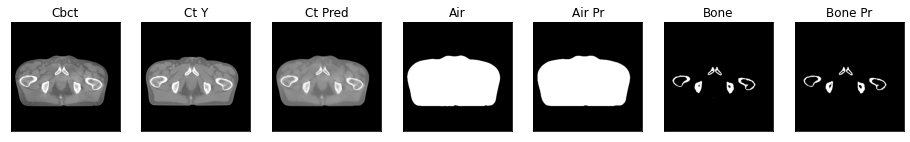

ssim score = 0.8912346959114075
psnr score = 25.559829711914062
snr score = 15.83320140838623
mae error = 0.018179986625909805
air dice score = 0.9988114144168452
bone dice score = 0.94800000000065


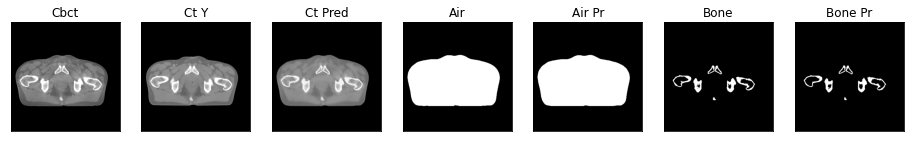

ssim score = 0.8886656761169434
psnr score = 25.639245986938477
snr score = 16.001867294311523
mae error = 0.018351539969444275
air dice score = 0.9984493021859853
bone dice score = 0.9369206420988365


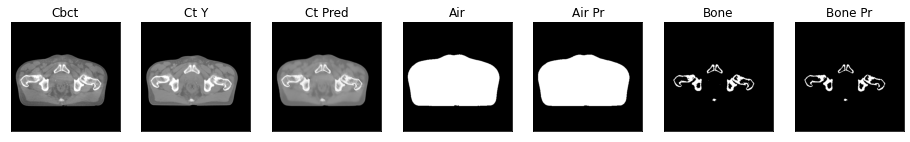

ssim score = 0.8876786231994629
psnr score = 25.80441665649414
snr score = 16.20734214782715
mae error = 0.0179582629352808
air dice score = 0.9984443842270613
bone dice score = 0.9310766721051073


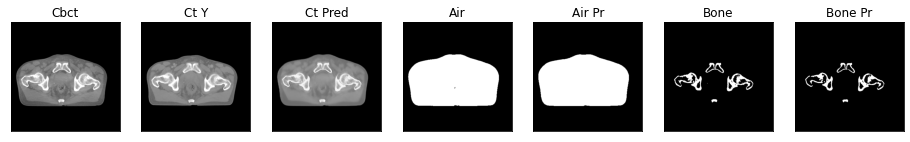

ssim score = 0.8828924894332886
psnr score = 25.806018829345703
snr score = 16.345478057861328
mae error = 0.018329301849007607
air dice score = 0.9983371796551428
bone dice score = 0.9326947746520765


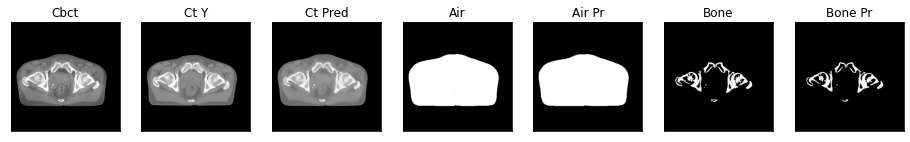

ssim score = 0.8820309042930603
psnr score = 25.696304321289062
snr score = 16.21170425415039
mae error = 0.01843392848968506
air dice score = 0.9980715750157338
bone dice score = 0.9417539267020472


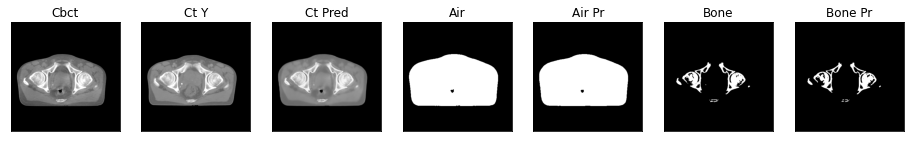

ssim score = 0.8852404356002808
psnr score = 26.144546508789062
snr score = 16.474411010742188
mae error = 0.017450964078307152
air dice score = 0.9983465000918628
bone dice score = 0.9441027496387111


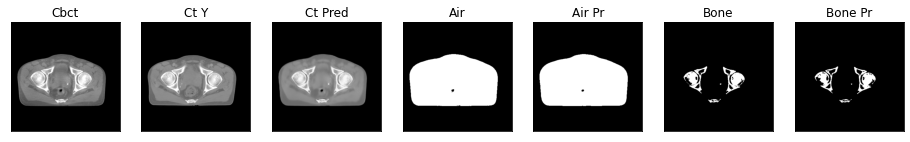

1it [00:02,  2.57s/it]

ssim score = 0.8882941603660583
psnr score = 26.47963523864746
snr score = 16.71494483947754
mae error = 0.016849517822265625
air dice score = 0.9984192157667846
bone dice score = 0.9531756159816122


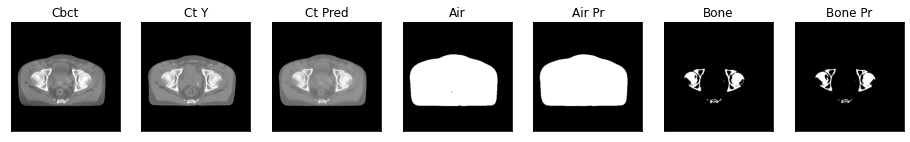

ssim score = 0.8920614719390869
psnr score = 26.552051544189453
snr score = 16.77208137512207
mae error = 0.016705043613910675
air dice score = 0.9984160998788799
bone dice score = 0.9515355575966582


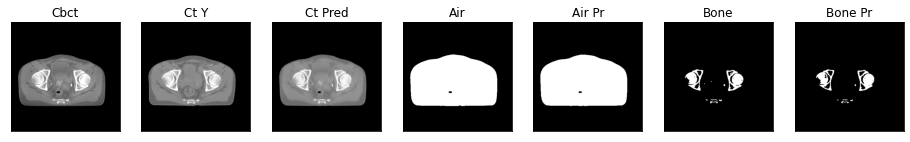

ssim score = 0.8991633653640747
psnr score = 26.84241485595703
snr score = 17.09471321105957
mae error = 0.016320982947945595
air dice score = 0.9983439742534882
bone dice score = 0.962466197945241


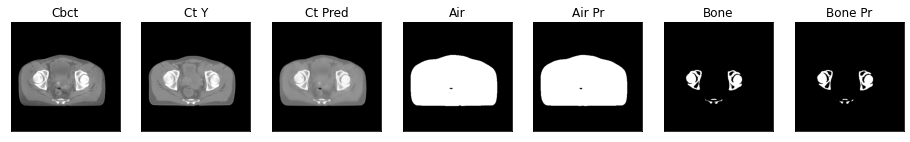

ssim score = 0.8982700705528259
psnr score = 26.000614166259766
snr score = 16.276622772216797
mae error = 0.017421264201402664
air dice score = 0.9982091690544431
bone dice score = 0.963724959394004


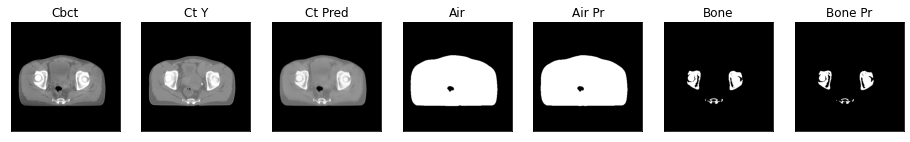

ssim score = 0.9028273820877075
psnr score = 25.33414649963379
snr score = 15.578231811523438
mae error = 0.018121862784028053
air dice score = 0.9981249866831461
bone dice score = 0.9691579068965097


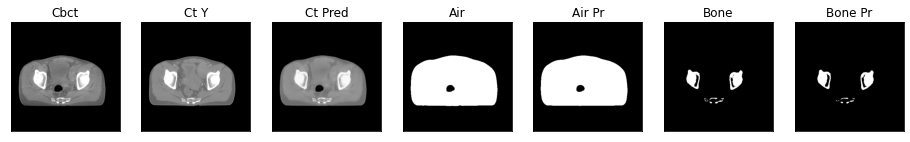

ssim score = 0.9001069068908691
psnr score = 25.11907958984375
snr score = 15.221209526062012
mae error = 0.01799091324210167
air dice score = 0.9978623527010647
bone dice score = 0.9446220744347791


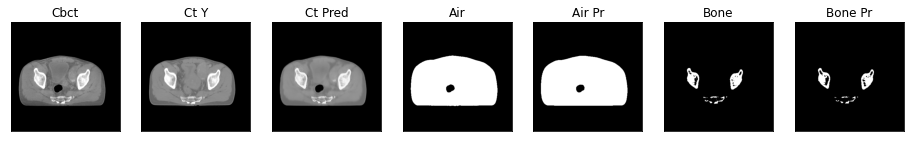

ssim score = 0.8969154953956604
psnr score = 25.038963317871094
snr score = 15.055431365966797
mae error = 0.01809125766158104
air dice score = 0.9980321345933459
bone dice score = 0.9349305744631782


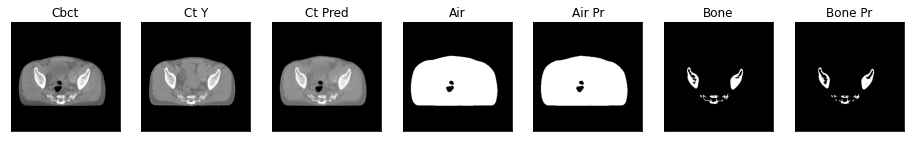

ssim score = 0.8916466236114502
psnr score = 24.70432472229004
snr score = 14.744277000427246
mae error = 0.018943380564451218
air dice score = 0.9982503233098251
bone dice score = 0.942721070923636


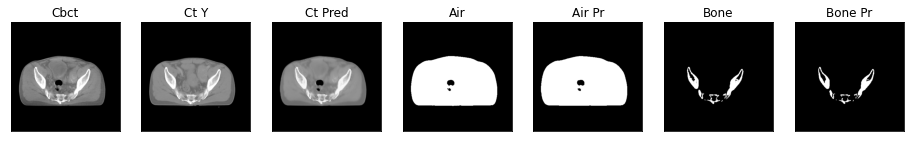

2it [00:04,  2.48s/it]

ssim score = 0.8872187733650208
psnr score = 23.937030792236328
snr score = 13.97443675994873
mae error = 0.020572317764163017
air dice score = 0.9981629981630001
bone dice score = 0.9461004988447973


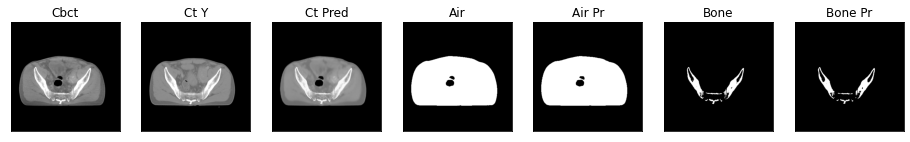

ssim score = 0.8796117901802063
psnr score = 23.355817794799805
snr score = 13.291464805603027
mae error = 0.02154722437262535
air dice score = 0.9976480030319608
bone dice score = 0.9349332013862577


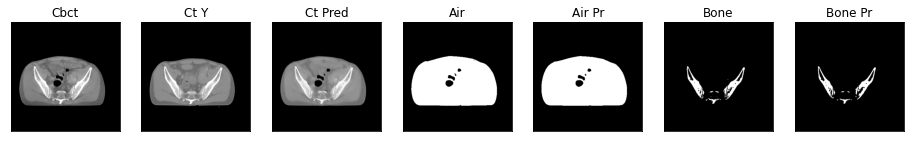

ssim score = 0.878179132938385
psnr score = 23.14887046813965
snr score = 13.033834457397461
mae error = 0.021871015429496765
air dice score = 0.9974145102183082
bone dice score = 0.9278325422912518


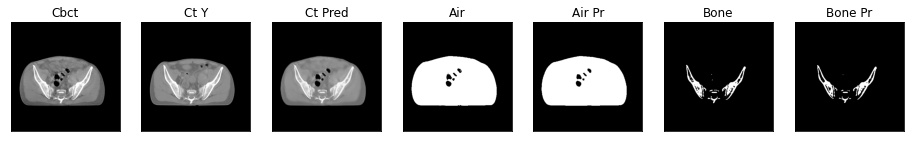

ssim score = 0.8804603815078735
psnr score = 23.042240142822266
snr score = 12.914896011352539
mae error = 0.02225596457719803
air dice score = 0.9974325623480208
bone dice score = 0.930846339297921


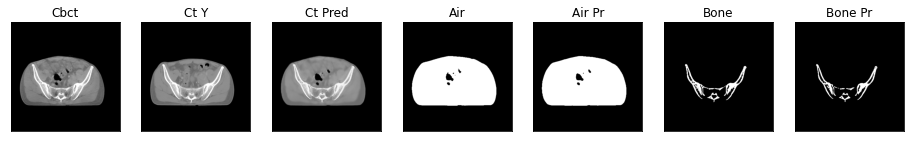

ssim score = 0.8786982893943787
psnr score = 22.925643920898438
snr score = 12.733451843261719
mae error = 0.022351233288645744
air dice score = 0.9983723180240187
bone dice score = 0.9247282234770231


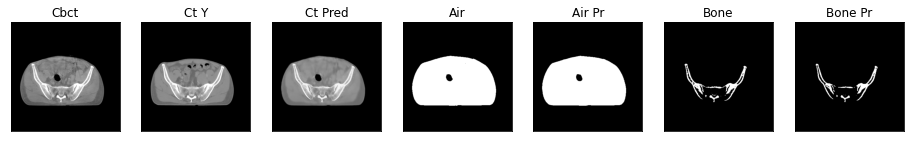

ssim score = 0.8757678270339966
psnr score = 22.91363525390625
snr score = 12.66201114654541
mae error = 0.02202698215842247
air dice score = 0.9976180338998681
bone dice score = 0.93107650643289


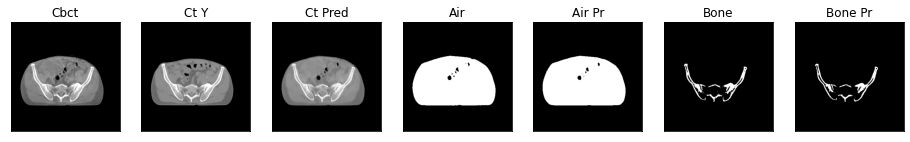

ssim score = 0.8793960809707642
psnr score = 23.031208038330078
snr score = 12.746160507202148
mae error = 0.02179221622645855
air dice score = 0.9980419191509599
bone dice score = 0.9262053971105486


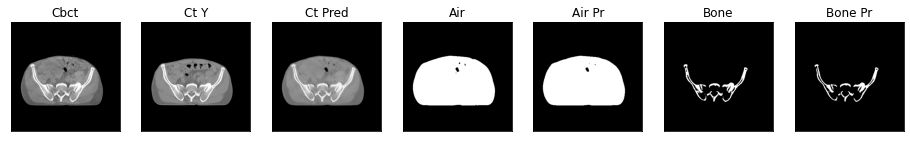

ssim score = 0.8792225122451782
psnr score = 23.025222778320312
snr score = 12.691608428955078
mae error = 0.021979928016662598
air dice score = 0.9978100223682232
bone dice score = 0.9251449007285097


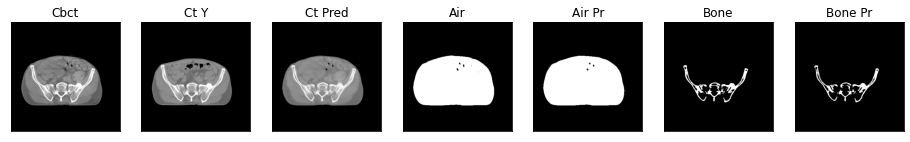

3it [00:07,  2.42s/it]

ssim score = 0.8807880282402039
psnr score = 22.965465545654297
snr score = 12.534852027893066
mae error = 0.022006196901202202
air dice score = 0.998528189910981
bone dice score = 0.9296173830901083


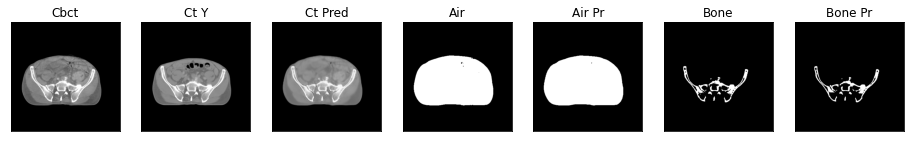

ssim score = 0.8846132755279541
psnr score = 23.168174743652344
snr score = 12.654828071594238
mae error = 0.021410439163446426
air dice score = 0.9980242663725312
bone dice score = 0.9241750526571005


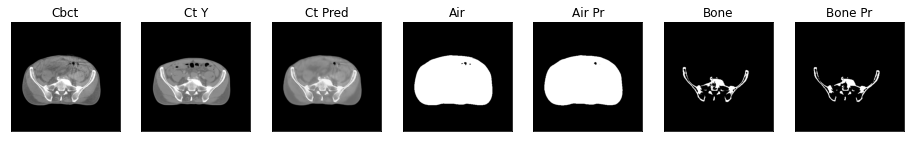

ssim score = 0.8838759064674377
psnr score = 23.29497528076172
snr score = 12.690441131591797
mae error = 0.02152331918478012
air dice score = 0.9981699475714733
bone dice score = 0.9325868372951028


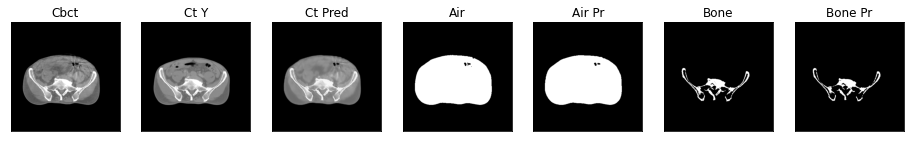

ssim score = 0.8854750990867615
psnr score = 23.19317626953125
snr score = 12.547534942626953
mae error = 0.021395646035671234
air dice score = 0.9974614823937499
bone dice score = 0.9333478782596994


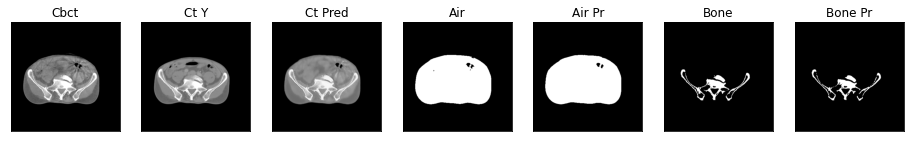

ssim score = 0.8689693212509155
psnr score = 23.922054290771484
snr score = 15.294210433959961
mae error = 0.02246055193245411
air dice score = 0.9988997524443006
bone dice score = 0.9806326662369066


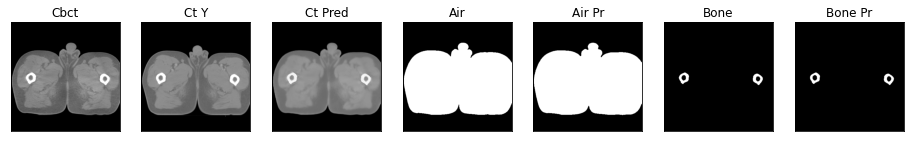

ssim score = 0.874226987361908
psnr score = 24.529762268066406
snr score = 15.941176414489746
mae error = 0.021243974566459656
air dice score = 0.998952632981526
bone dice score = 0.9783523752261469


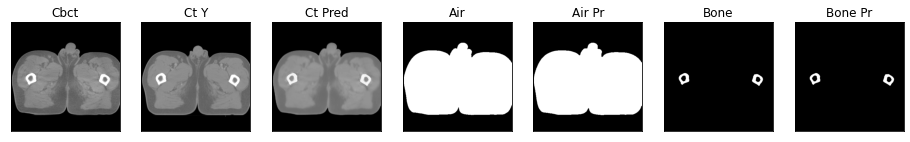

ssim score = 0.8834472894668579
psnr score = 25.13018798828125
snr score = 16.629051208496094
mae error = 0.020313704386353493
air dice score = 0.9991877422927825
bone dice score = 0.970757430489675


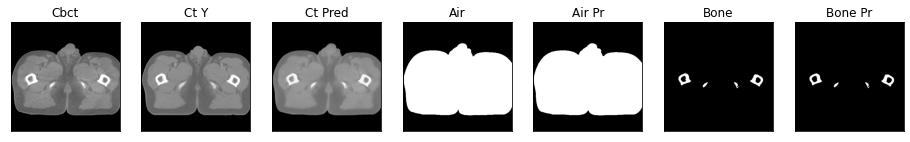

ssim score = 0.8872888684272766
psnr score = 25.534990310668945
snr score = 17.1964111328125
mae error = 0.019826790317893028
air dice score = 0.9990643289159064
bone dice score = 0.9616713275216043


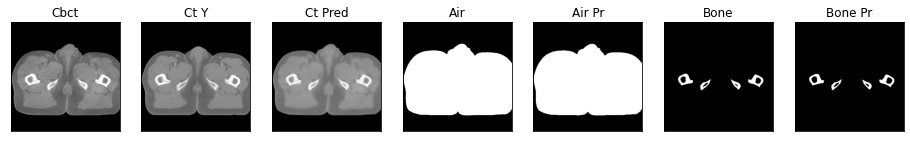

4it [00:09,  2.31s/it]

ssim score = 0.8884890079498291
psnr score = 25.768709182739258
snr score = 17.558273315429688
mae error = 0.019682249054312706
air dice score = 0.9990014734355408
bone dice score = 0.9592592592598396


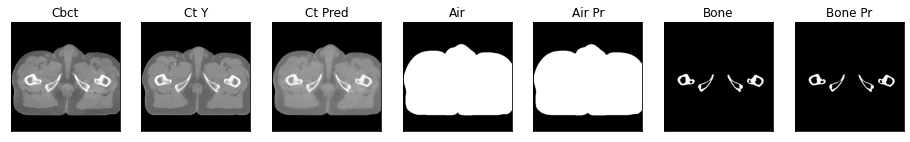

ssim score = 0.890428364276886
psnr score = 26.249805450439453
snr score = 18.142606735229492
mae error = 0.01911841705441475
air dice score = 0.9990601560747273
bone dice score = 0.9507910801052598


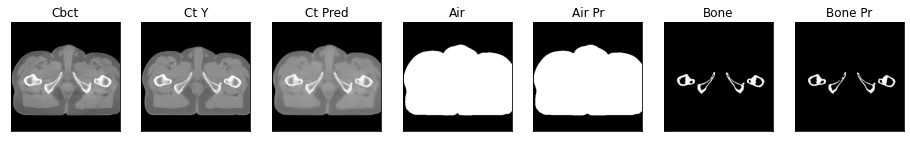

ssim score = 0.8917174339294434
psnr score = 26.595800399780273
snr score = 18.555702209472656
mae error = 0.01935548521578312
air dice score = 0.9989549795526352
bone dice score = 0.946802425352399


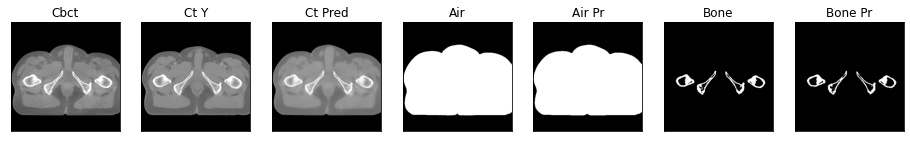

ssim score = 0.8905773758888245
psnr score = 26.641977310180664
snr score = 18.59198760986328
mae error = 0.01933813840150833
air dice score = 0.9989762859654834
bone dice score = 0.9528626775726123


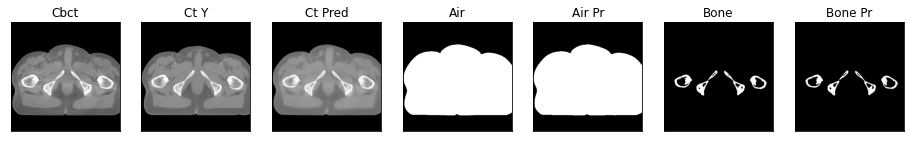

ssim score = 0.8927810788154602
psnr score = 26.768333435058594
snr score = 18.704683303833008
mae error = 0.019004710018634796
air dice score = 0.9990383575146355
bone dice score = 0.9590320526431858


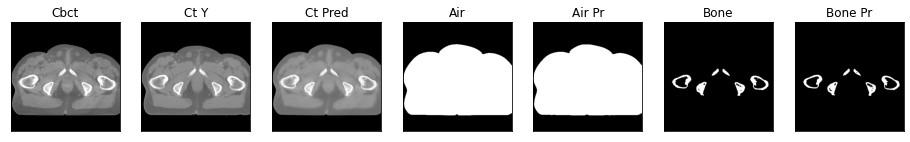

ssim score = 0.8921127319335938
psnr score = 26.74419403076172
snr score = 18.692543029785156
mae error = 0.019412456080317497
air dice score = 0.9989497374343592
bone dice score = 0.9543204320437183


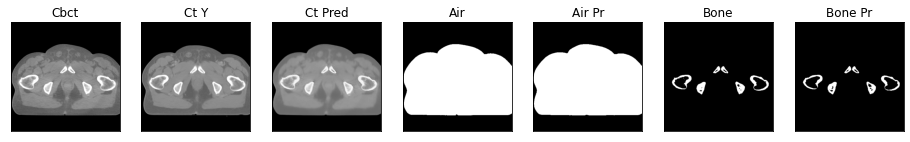

ssim score = 0.8935494422912598
psnr score = 26.804306030273438
snr score = 18.79174041748047
mae error = 0.0192582905292511
air dice score = 0.9990822661428191
bone dice score = 0.9552822163472205


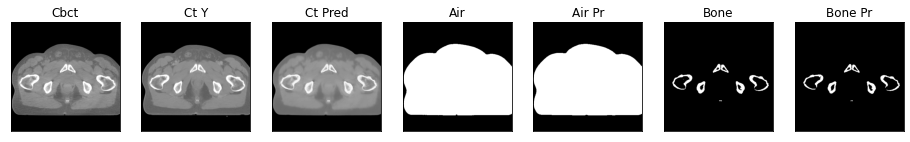

ssim score = 0.8900351524353027
psnr score = 26.74424934387207
snr score = 18.87297248840332
mae error = 0.01984924077987671
air dice score = 0.9989683301343576
bone dice score = 0.9513662819379366


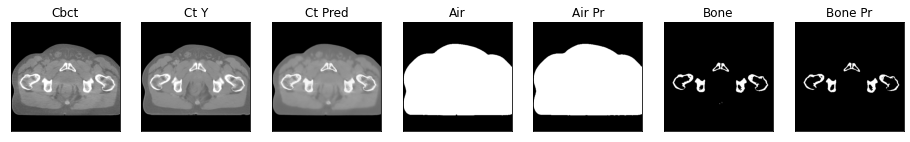

5it [00:11,  2.32s/it]

ssim score = 0.8902336359024048
psnr score = 27.029621124267578
snr score = 19.25303077697754
mae error = 0.0196731835603714
air dice score = 0.9987148227776651
bone dice score = 0.9547976501309171


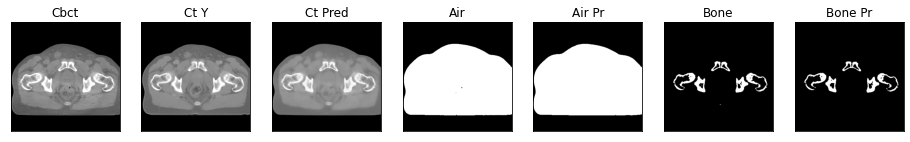

ssim score = 0.8797466158866882
psnr score = 26.390592575073242
snr score = 18.5799560546875
mae error = 0.021113352850079536
air dice score = 0.9983662593367384
bone dice score = 0.9311734364931401


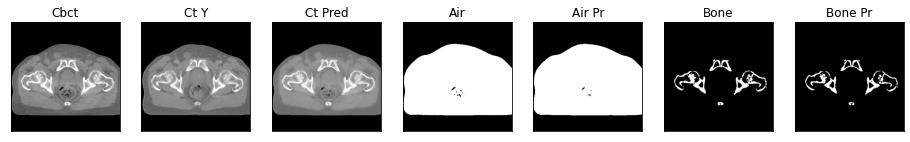

ssim score = 0.8820266723632812
psnr score = 25.981121063232422
snr score = 18.2426700592041
mae error = 0.021115025505423546
air dice score = 0.997990273164987
bone dice score = 0.9331333924072447


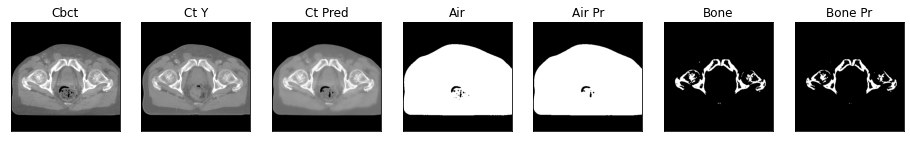

ssim score = 0.8814280033111572
psnr score = 25.91954803466797
snr score = 18.045001983642578
mae error = 0.020999321714043617
air dice score = 0.9987879969060431
bone dice score = 0.9226941531906638


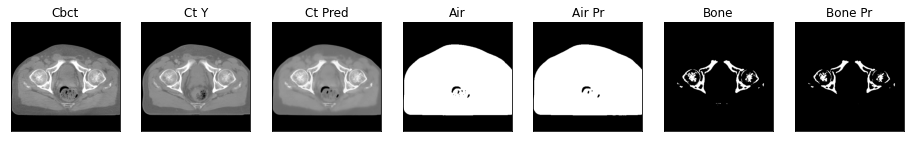

ssim score = 0.8861159086227417
psnr score = 25.872344970703125
snr score = 17.819238662719727
mae error = 0.02030951902270317
air dice score = 0.9986323116375634
bone dice score = 0.92400000000076


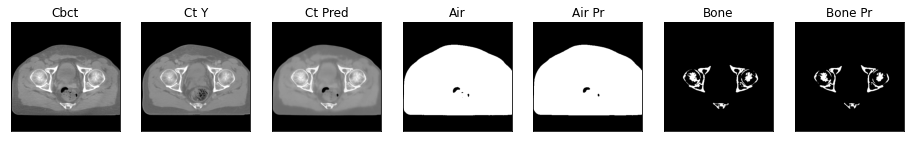

ssim score = 0.8850133419036865
psnr score = 25.952056884765625
snr score = 17.808364868164062
mae error = 0.02059018239378929
air dice score = 0.9988569612283701
bone dice score = 0.9162214391279274


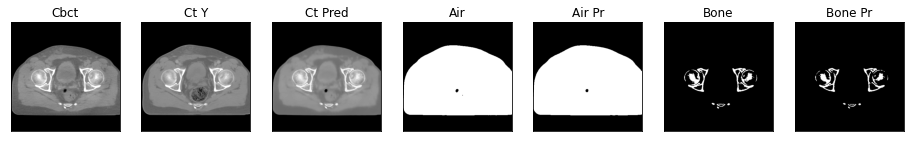

ssim score = 0.8847752213478088
psnr score = 25.969280242919922
snr score = 17.841278076171875
mae error = 0.020331161096692085
air dice score = 0.9989509009368277
bone dice score = 0.9339612768191108


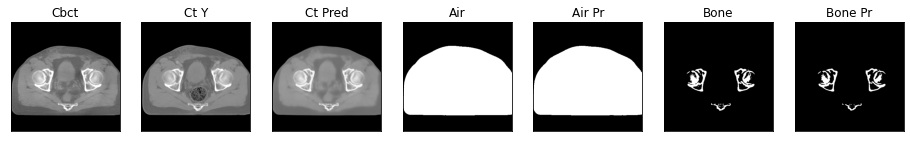

ssim score = 0.8737446069717407
psnr score = 25.695205688476562
snr score = 17.577232360839844
mae error = 0.021700697019696236
air dice score = 0.9988219693465329
bone dice score = 0.9384905660383162


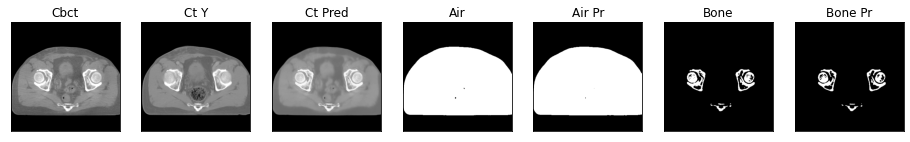

6it [00:13,  2.26s/it]

ssim score = 0.8814923167228699
psnr score = 26.14632797241211
snr score = 18.089950561523438
mae error = 0.020994674414396286
air dice score = 0.998675513083951
bone dice score = 0.949785837966374


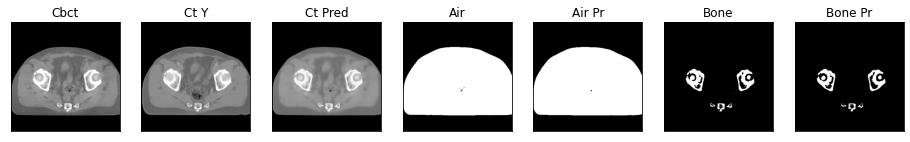

ssim score = 0.8825752139091492
psnr score = 26.637725830078125
snr score = 18.65142822265625
mae error = 0.020647339522838593
air dice score = 0.9985416679595152
bone dice score = 0.9650374284459265


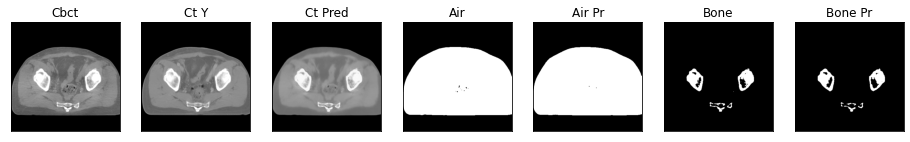

ssim score = 0.8816006183624268
psnr score = 26.08841323852539
snr score = 17.983013153076172
mae error = 0.02121845819056034
air dice score = 0.9985912083956541
bone dice score = 0.960289514867368


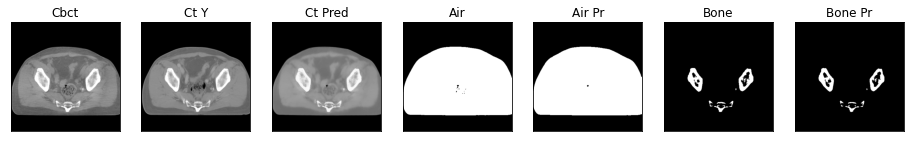

ssim score = 0.8751780986785889
psnr score = 25.47011375427246
snr score = 17.446338653564453
mae error = 0.02305849827826023
air dice score = 0.9983247710520449
bone dice score = 0.9568339174292091


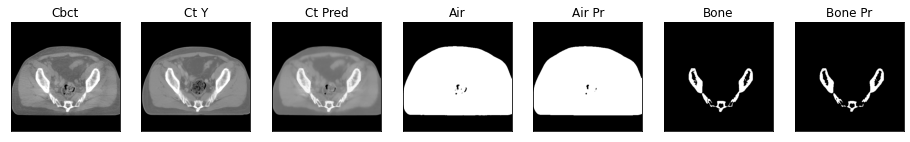

ssim score = 0.8756621479988098
psnr score = 25.554798126220703
snr score = 17.611167907714844
mae error = 0.02296140417456627
air dice score = 0.9984744753683593
bone dice score = 0.9588474431213262


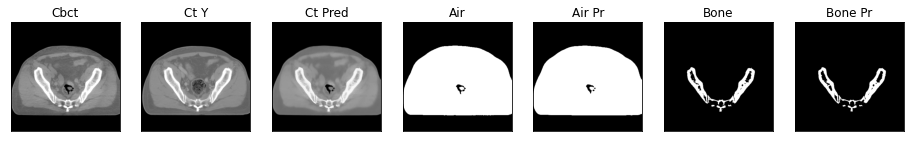

ssim score = 0.8635258078575134
psnr score = 24.990257263183594
snr score = 17.068187713623047
mae error = 0.024888629093766212
air dice score = 0.9988253913301524
bone dice score = 0.9472774416598438


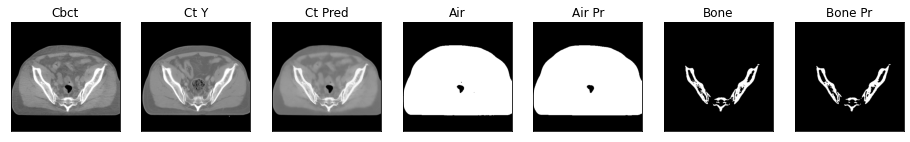

ssim score = 0.8664239048957825
psnr score = 25.500835418701172
snr score = 17.59130096435547
mae error = 0.02425653673708439
air dice score = 0.998791892803484
bone dice score = 0.9487819195777166


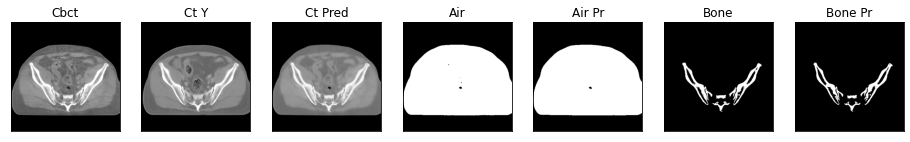

ssim score = 0.819126546382904
psnr score = 21.384428024291992
snr score = 11.26463508605957
mae error = 0.03184681013226509
air dice score = 0.9862759643917042
bone dice score = 0.9553167420827117


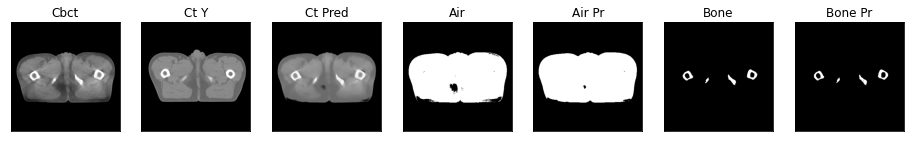

7it [00:15,  2.28s/it]

ssim score = 0.8077307939529419
psnr score = 20.9676456451416
snr score = 11.060833930969238
mae error = 0.03417365998029709
air dice score = 0.9874200485477332
bone dice score = 0.9438763917304277


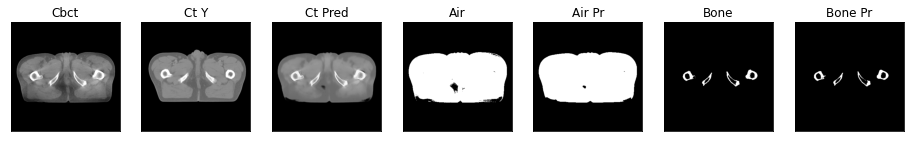

ssim score = 0.8031412363052368
psnr score = 20.962841033935547
snr score = 11.18716812133789
mae error = 0.03462062403559685
air dice score = 0.9869481871463152
bone dice score = 0.9150098317693902


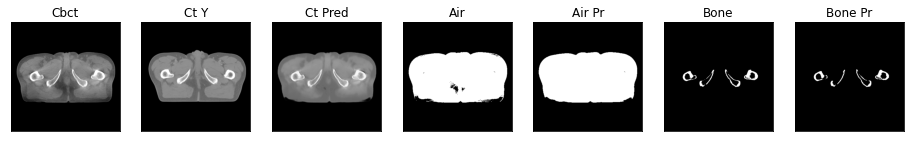

ssim score = 0.8062412738800049
psnr score = 21.251304626464844
snr score = 11.546031951904297
mae error = 0.033582113683223724
air dice score = 0.9860339555767893
bone dice score = 0.9215274863633754


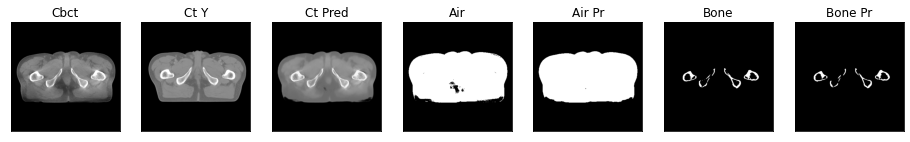

ssim score = 0.808106005191803
psnr score = 21.28912925720215
snr score = 11.631426811218262
mae error = 0.0334489531815052
air dice score = 0.9877506179621095
bone dice score = 0.9065843621418398


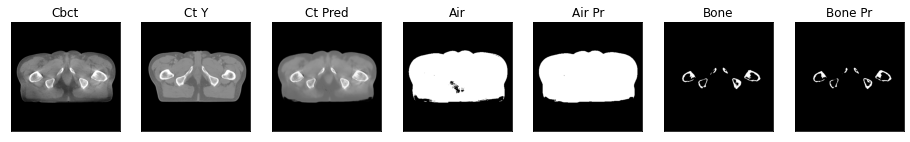

ssim score = 0.8113529682159424
psnr score = 21.456377029418945
snr score = 11.804288864135742
mae error = 0.0328286737203598
air dice score = 0.988187610684107
bone dice score = 0.9173913043494587


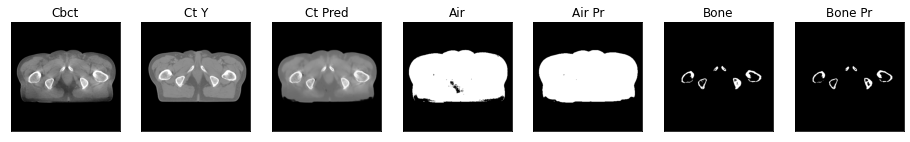

ssim score = 0.8140722513198853
psnr score = 21.583267211914062
snr score = 11.924675941467285
mae error = 0.03225386515259743
air dice score = 0.9885715844311808
bone dice score = 0.9182111200661118


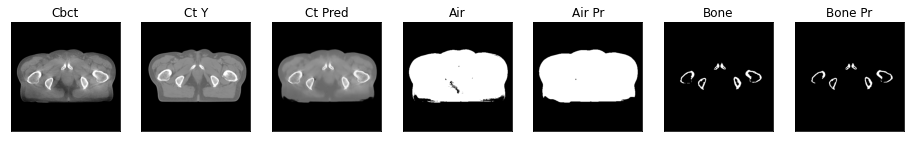

ssim score = 0.8135128021240234
psnr score = 21.487987518310547
snr score = 11.843505859375
mae error = 0.03242431581020355
air dice score = 0.9901521448447922
bone dice score = 0.9355404089593857


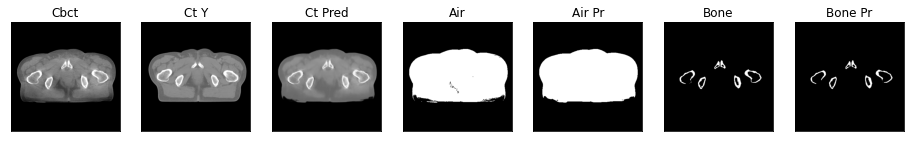

ssim score = 0.8123056292533875
psnr score = 21.43706512451172
snr score = 11.850591659545898
mae error = 0.033172059804201126
air dice score = 0.9907713362204879
bone dice score = 0.9257657034101788


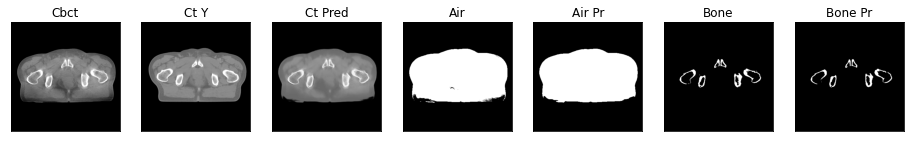

8it [00:18,  2.22s/it]

ssim score = 0.8026788830757141
psnr score = 21.203134536743164
snr score = 11.715222358703613
mae error = 0.0350426509976387
air dice score = 0.9915261860640919
bone dice score = 0.9083704804373721


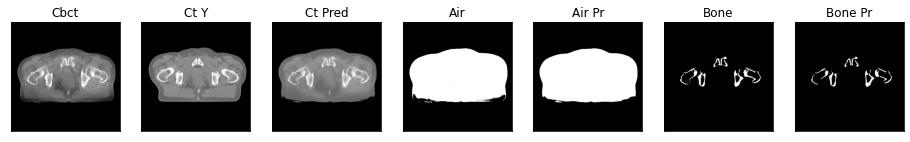

ssim score = 0.7905505299568176
psnr score = 21.03990936279297
snr score = 11.587823867797852
mae error = 0.03625527396798134
air dice score = 0.9910000538919009
bone dice score = 0.9003795066429415


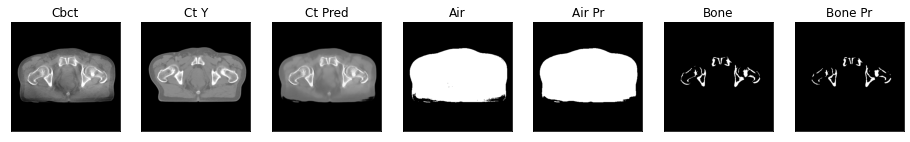

ssim score = 0.7792804837226868
psnr score = 20.954742431640625
snr score = 11.53536319732666
mae error = 0.03633048012852669
air dice score = 0.9905851550311222
bone dice score = 0.8800453193615628


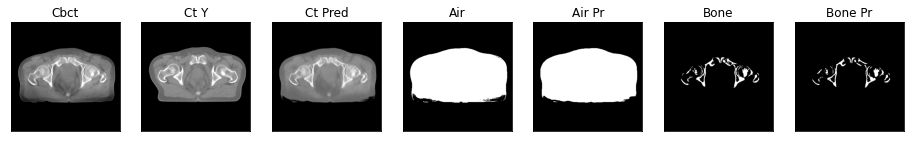

ssim score = 0.7809109091758728
psnr score = 20.917091369628906
snr score = 11.61452865600586
mae error = 0.03702628239989281
air dice score = 0.9898937455802012
bone dice score = 0.9047684865251587


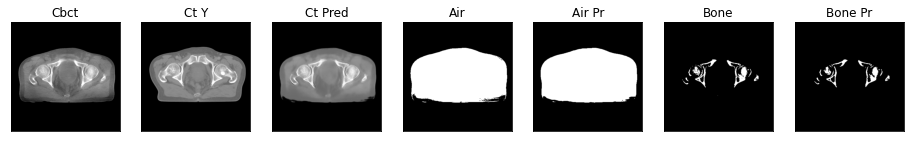

ssim score = 0.7857272624969482
psnr score = 20.877307891845703
snr score = 11.558761596679688
mae error = 0.03704852610826492
air dice score = 0.9886309763406337
bone dice score = 0.8790931989943468


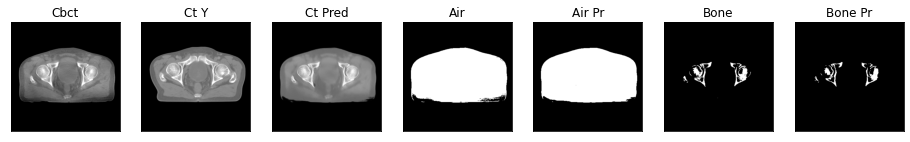

ssim score = 0.8004299402236938
psnr score = 21.48358154296875
snr score = 11.965869903564453
mae error = 0.03335534408688545
air dice score = 0.9868973776880156
bone dice score = 0.9079386257520358


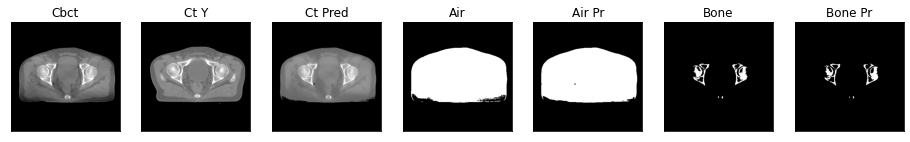

ssim score = 0.8170597553253174
psnr score = 22.181835174560547
snr score = 12.493732452392578
mae error = 0.03033672831952572
air dice score = 0.9870790427069878
bone dice score = 0.9397014925382134


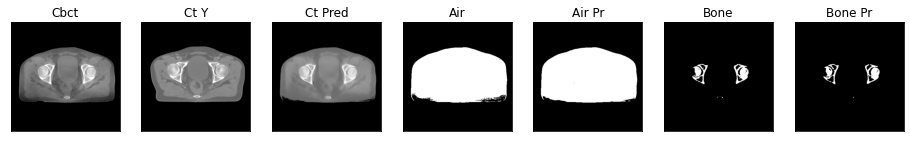

ssim score = 0.8246158361434937
psnr score = 22.470298767089844
snr score = 12.796361923217773
mae error = 0.02927406318485737
air dice score = 0.9875360739079657
bone dice score = 0.935061315497003


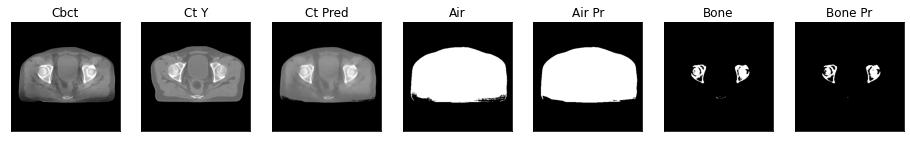

9it [00:20,  2.25s/it]

ssim score = 0.8277413845062256
psnr score = 22.52596664428711
snr score = 12.933856964111328
mae error = 0.029367545619606972
air dice score = 0.9879996423142376
bone dice score = 0.9512025580432197


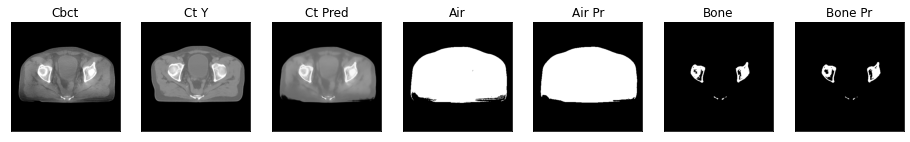

ssim score = 0.8262910842895508
psnr score = 22.25834846496582
snr score = 12.758415222167969
mae error = 0.030695024877786636
air dice score = 0.9876337884600019
bone dice score = 0.9334182860794294


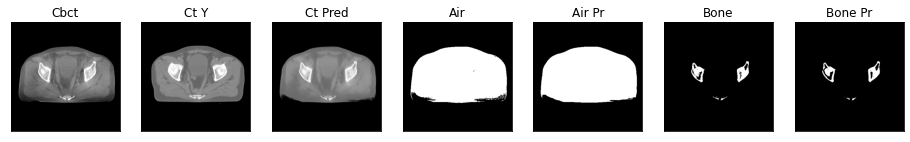

ssim score = 0.8234820365905762
psnr score = 22.681903839111328
snr score = 13.118542671203613
mae error = 0.029194070026278496
air dice score = 0.9870612928080031
bone dice score = 0.9515570934264437


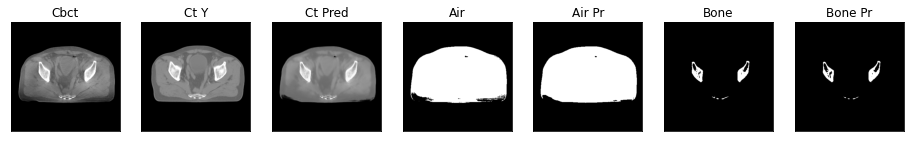

ssim score = 0.8289567828178406
psnr score = 22.97372055053711
snr score = 13.3739652633667
mae error = 0.027995791286230087
air dice score = 0.9862352899600786
bone dice score = 0.9472305389231431


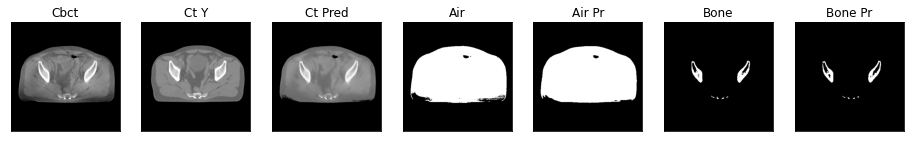

ssim score = 0.8249230980873108
psnr score = 22.842199325561523
snr score = 13.280190467834473
mae error = 0.029179295524954796
air dice score = 0.9861491937261524
bone dice score = 0.9204406364762994


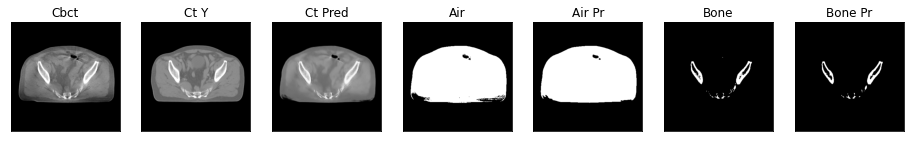

ssim score = 0.8222153782844543
psnr score = 22.785140991210938
snr score = 13.353635787963867
mae error = 0.029793867841362953
air dice score = 0.9864357813518537
bone dice score = 0.9234016887828196


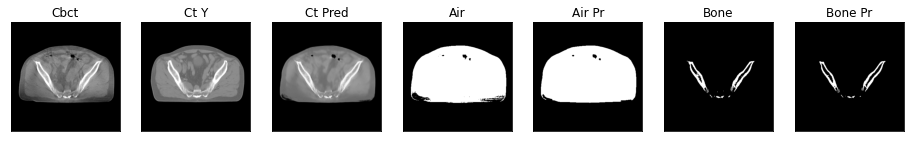

ssim score = 0.8229580521583557
psnr score = 22.724918365478516
snr score = 13.311162948608398
mae error = 0.02996426448225975
air dice score = 0.9857319223986016
bone dice score = 0.8927680798022815


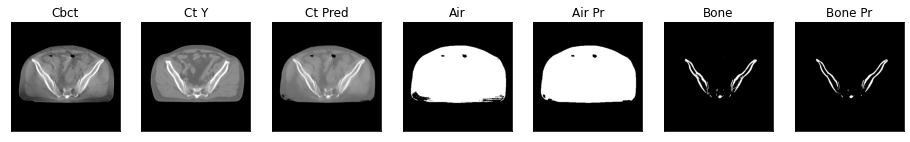

ssim score = 0.8254396915435791
psnr score = 23.121442794799805
snr score = 13.696417808532715
mae error = 0.028835704550147057
air dice score = 0.9861669686657655
bone dice score = 0.9088937093291957


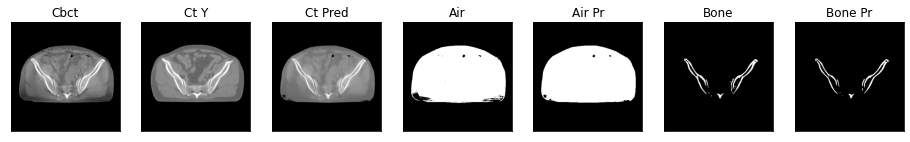

10it [00:22,  2.27s/it]

ssim score = 0.8270450830459595
psnr score = 23.183765411376953
snr score = 13.758000373840332
mae error = 0.028531508520245552
air dice score = 0.9859654096966385
bone dice score = 0.9027656983840187


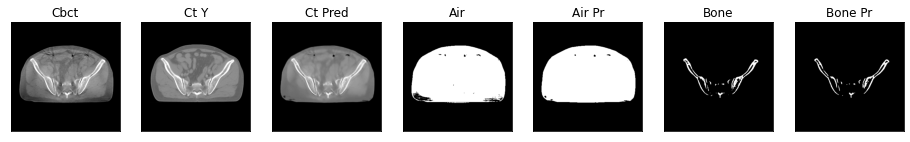

ssim score = 0.8818036317825317
psnr score = 24.7268123626709
snr score = 15.160945892333984
mae error = 0.0199032761156559
air dice score = 0.9985980178873591
bone dice score = 0.9551282051300028


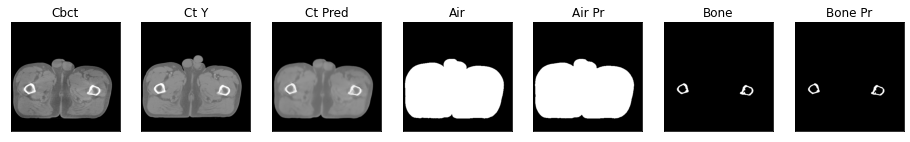

ssim score = 0.879965603351593
psnr score = 24.95140838623047
snr score = 15.449935913085938
mae error = 0.019747477024793625
air dice score = 0.9982530651494524
bone dice score = 0.928355957770424


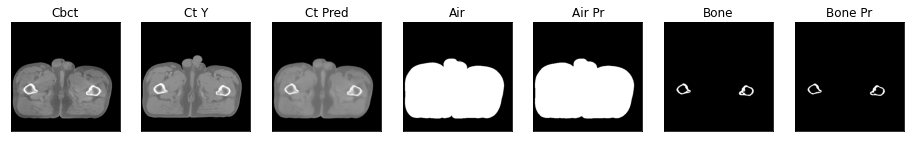

ssim score = 0.886155903339386
psnr score = 26.59353256225586
snr score = 17.23126983642578
mae error = 0.01838434487581253
air dice score = 0.9980745917421394
bone dice score = 0.9470434576122764


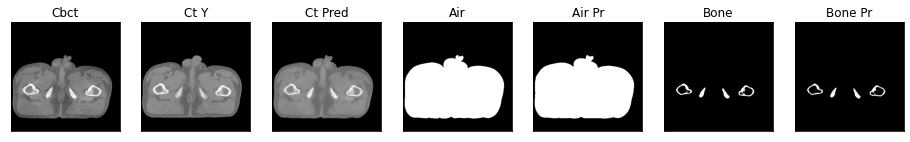

ssim score = 0.8872826099395752
psnr score = 26.39174461364746
snr score = 17.15097427368164
mae error = 0.019074922427535057
air dice score = 0.9982986231450279
bone dice score = 0.9353211009189146


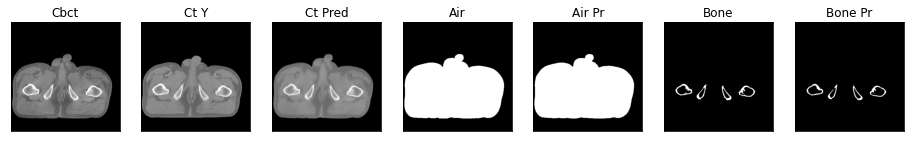

ssim score = 0.8835822343826294
psnr score = 26.16855239868164
snr score = 16.951953887939453
mae error = 0.0192182008177042
air dice score = 0.9983577058171802
bone dice score = 0.9261363636381122


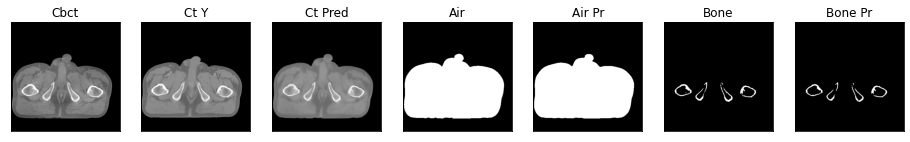

ssim score = 0.8838078379631042
psnr score = 26.01311683654785
snr score = 16.792123794555664
mae error = 0.019175169989466667
air dice score = 0.9984151393422056
bone dice score = 0.9199044931643172


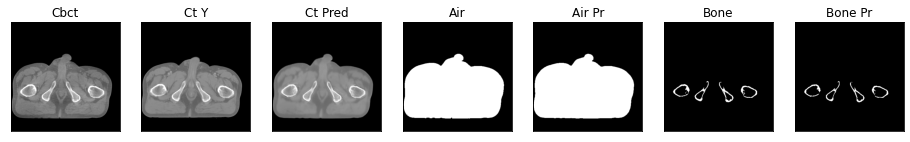

ssim score = 0.8844510316848755
psnr score = 25.483247756958008
snr score = 16.26850700378418
mae error = 0.020017795264720917
air dice score = 0.9981884200042362
bone dice score = 0.9154419595332174


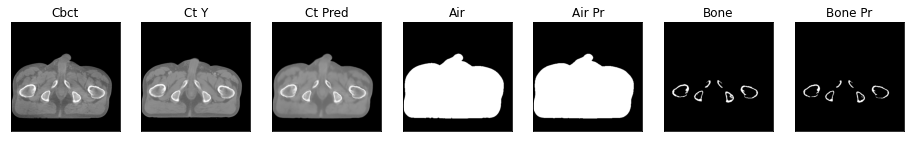

11it [00:24,  2.22s/it]

ssim score = 0.8831670880317688
psnr score = 25.216289520263672
snr score = 15.979994773864746
mae error = 0.0200346652418375
air dice score = 0.9984535070848228
bone dice score = 0.9257238774669382


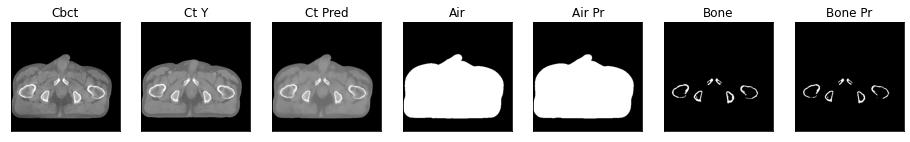

ssim score = 0.8838052153587341
psnr score = 25.241886138916016
snr score = 16.022499084472656
mae error = 0.020084701478481293
air dice score = 0.9984880461145947
bone dice score = 0.9299412915864982


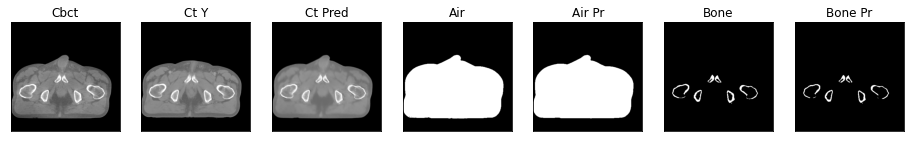

ssim score = 0.8851646184921265
psnr score = 25.620155334472656
snr score = 16.4693660736084
mae error = 0.019634362310171127
air dice score = 0.9984902498596971
bone dice score = 0.934013725146331


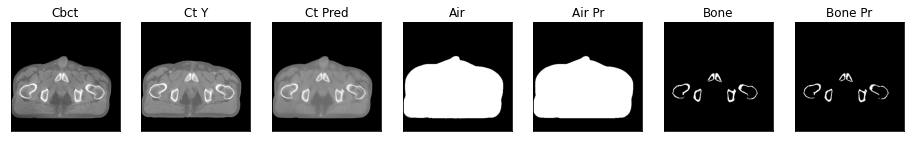

ssim score = 0.884951114654541
psnr score = 26.094167709350586
snr score = 17.024734497070312
mae error = 0.019174933433532715
air dice score = 0.9986987018757747
bone dice score = 0.9254357650108871


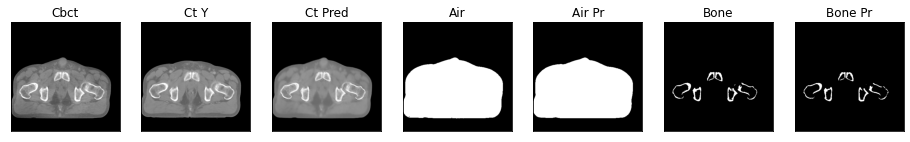

ssim score = 0.886779248714447
psnr score = 26.575448989868164
snr score = 17.556720733642578
mae error = 0.018783895298838615
air dice score = 0.9986616958225801
bone dice score = 0.9152489947430367


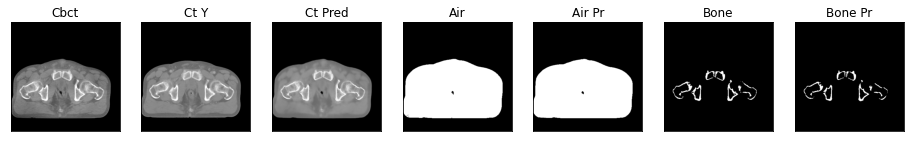

ssim score = 0.8892464637756348
psnr score = 27.028085708618164
snr score = 18.125627517700195
mae error = 0.01827644184231758
air dice score = 0.998657739569519
bone dice score = 0.8925454285320855


ssim score = 0.8903030157089233
psnr score = 26.692495346069336
snr score = 17.751798629760742
mae error = 0.018271885812282562
air dice score = 0.9982634422433767
bone dice score = 0.9002298850590003


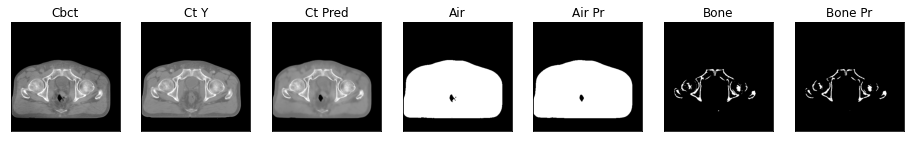

ssim score = 0.8845946192741394
psnr score = 25.911365509033203
snr score = 16.874996185302734
mae error = 0.01900472678244114
air dice score = 0.9978320003247957
bone dice score = 0.8974613530010288


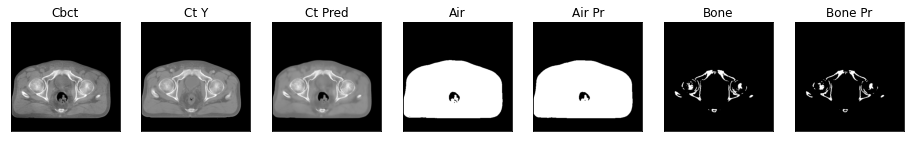

12it [00:27,  2.24s/it]

ssim score = 0.8884196281433105
psnr score = 25.741025924682617
snr score = 16.544898986816406
mae error = 0.018805155530571938
air dice score = 0.9975720019947208
bone dice score = 0.899076048331573


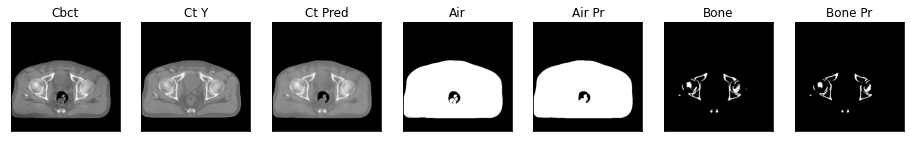

ssim score = 0.8864126205444336
psnr score = 25.20970916748047
snr score = 15.897159576416016
mae error = 0.019305603578686714
air dice score = 0.9981990615293121
bone dice score = 0.8913649025089811


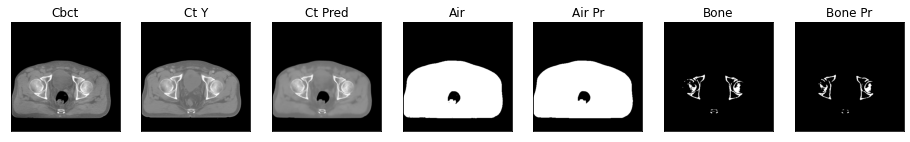

ssim score = 0.8832452297210693
psnr score = 25.097705841064453
snr score = 15.740060806274414
mae error = 0.01940116286277771
air dice score = 0.9982041304998518
bone dice score = 0.9183050847471473


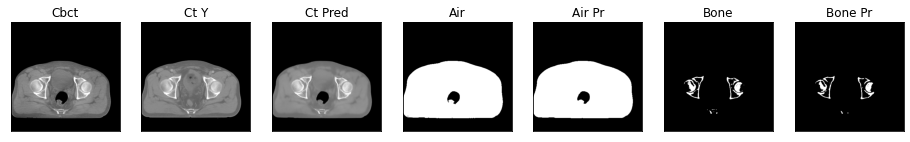

ssim score = 0.8774526715278625
psnr score = 24.38317108154297
snr score = 15.032197952270508
mae error = 0.021041231229901314
air dice score = 0.9981835149818367
bone dice score = 0.9316540722093761


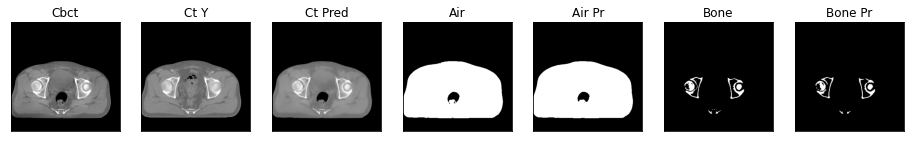

ssim score = 0.8794537782669067
psnr score = 23.938739776611328
snr score = 14.617870330810547
mae error = 0.022109830752015114
air dice score = 0.9982297337920453
bone dice score = 0.9476145930784594


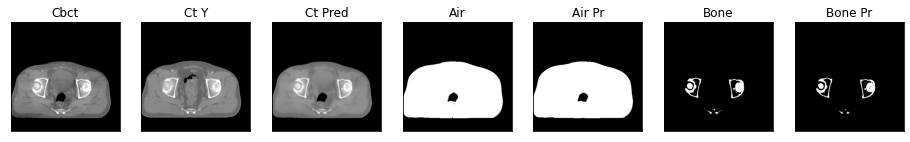

ssim score = 0.885408878326416
psnr score = 24.657079696655273
snr score = 15.293625831604004
mae error = 0.0206897035241127
air dice score = 0.9982571278467621
bone dice score = 0.9364466292145989


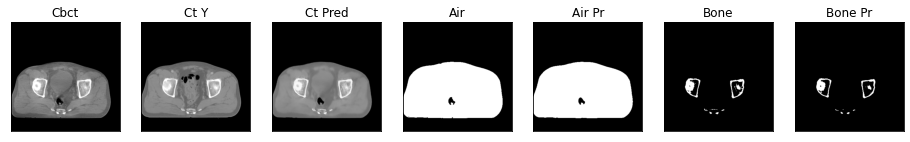

ssim score = 0.888155460357666
psnr score = 25.004802703857422
snr score = 15.551143646240234
mae error = 0.019324036315083504
air dice score = 0.9980757324766176
bone dice score = 0.9251538614269376


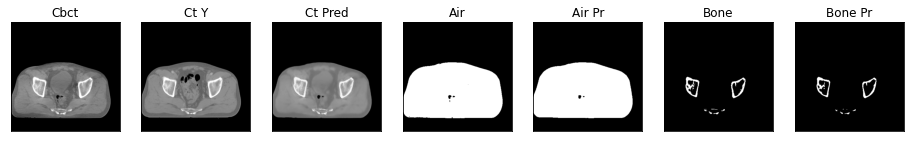

ssim score = 0.8878671526908875
psnr score = 24.63039779663086
snr score = 15.111013412475586
mae error = 0.019815802574157715
air dice score = 0.9983192709521048
bone dice score = 0.9363096457109091


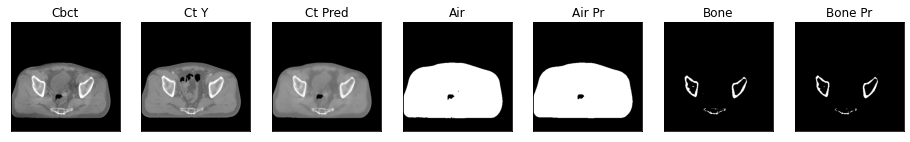

13it [00:29,  2.20s/it]

ssim score = 0.8854190111160278
psnr score = 24.721771240234375
snr score = 15.202083587646484
mae error = 0.019983256235718727
air dice score = 0.9979021336835481
bone dice score = 0.9429235999294521


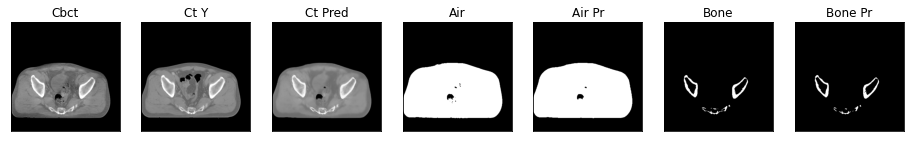

ssim score = 0.8780654072761536
psnr score = 24.629926681518555
snr score = 15.186405181884766
mae error = 0.021103810518980026
air dice score = 0.9979151949551182
bone dice score = 0.9292632814803454


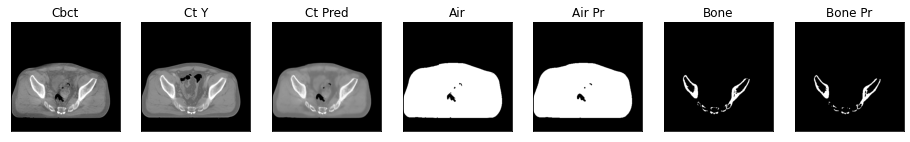

ssim score = 0.8851514458656311
psnr score = 24.851856231689453
snr score = 15.443916320800781
mae error = 0.02045801840722561
air dice score = 0.9968817587228267
bone dice score = 0.9252630140739819


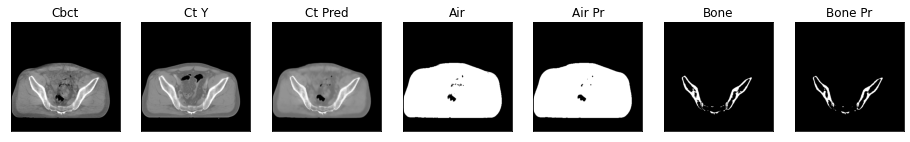

ssim score = 0.8869679570198059
psnr score = 25.54889488220215
snr score = 16.079256057739258
mae error = 0.0193036999553442
air dice score = 0.9970316565102783
bone dice score = 0.9069733156434178


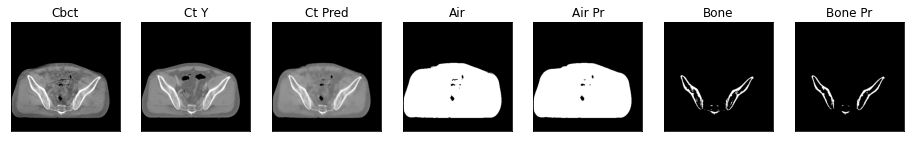

ssim score = 0.8827583193778992
psnr score = 25.24291229248047
snr score = 15.712017059326172
mae error = 0.019866619259119034
air dice score = 0.9965256344685309
bone dice score = 0.9057769539711804


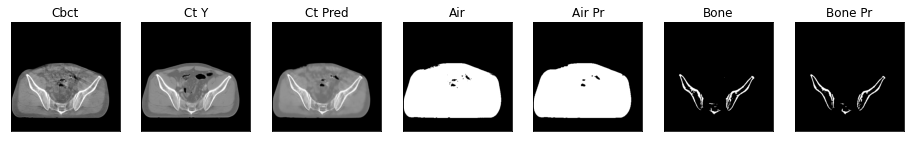

ssim score = 0.8198269605636597
psnr score = 22.588727951049805
snr score = 14.286033630371094
mae error = 0.029771622270345688
air dice score = 0.9988339900859267
bone dice score = 0.9668615984416224


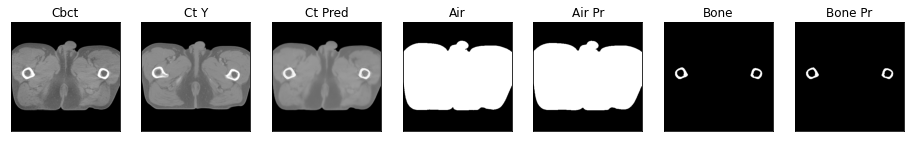

ssim score = 0.8103571534156799
psnr score = 22.265064239501953
snr score = 14.066662788391113
mae error = 0.030973536893725395
air dice score = 0.9989658861286111
bone dice score = 0.9668218859148189


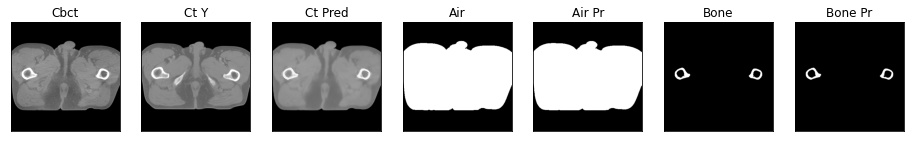

ssim score = 0.8040010929107666
psnr score = 22.046030044555664
snr score = 13.975584030151367
mae error = 0.03246917203068733
air dice score = 0.9989989515646571
bone dice score = 0.9379474940348939


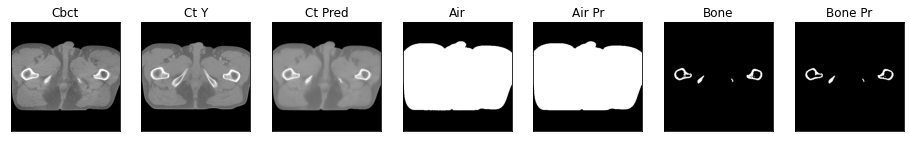

14it [00:31,  2.23s/it]

ssim score = 0.7962514758110046
psnr score = 21.8070125579834
snr score = 13.768856048583984
mae error = 0.03304252400994301
air dice score = 0.9987654831450062
bone dice score = 0.9414248021118483


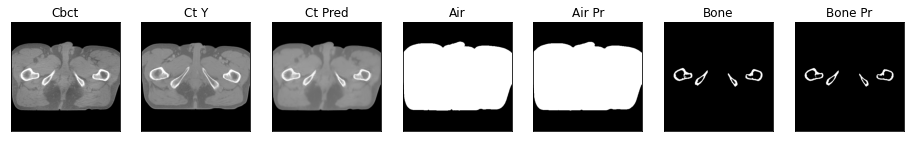

ssim score = 0.7867041826248169
psnr score = 21.656129837036133
snr score = 13.648212432861328
mae error = 0.034097205847501755
air dice score = 0.9987336926112443
bone dice score = 0.9367689438898666


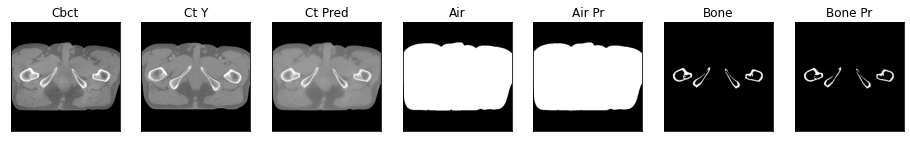

ssim score = 0.7798430323600769
psnr score = 21.541730880737305
snr score = 13.568228721618652
mae error = 0.03538172319531441
air dice score = 0.9986207382278549
bone dice score = 0.9460105112287623


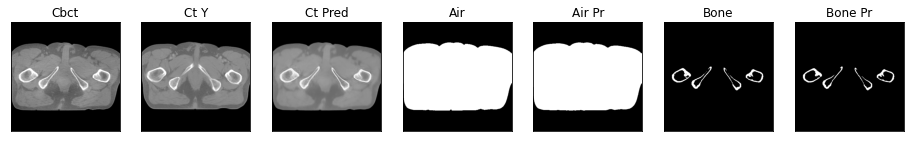

ssim score = 0.7721943259239197
psnr score = 21.292428970336914
snr score = 13.339237213134766
mae error = 0.03655942901968956
air dice score = 0.9984262471552525
bone dice score = 0.9401998030119573


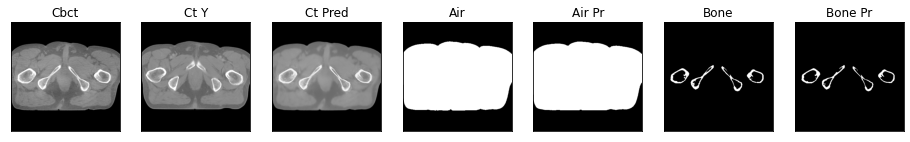

ssim score = 0.7721026539802551
psnr score = 21.330554962158203
snr score = 13.416435241699219
mae error = 0.03593054413795471
air dice score = 0.9988253925584827
bone dice score = 0.9362119725229747


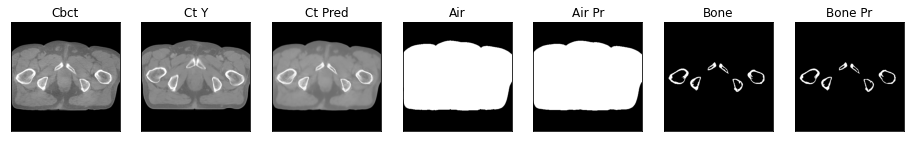

ssim score = 0.772881269454956
psnr score = 21.49144172668457
snr score = 13.626004219055176
mae error = 0.0355362743139267
air dice score = 0.9990059990878586
bone dice score = 0.9345060893107645


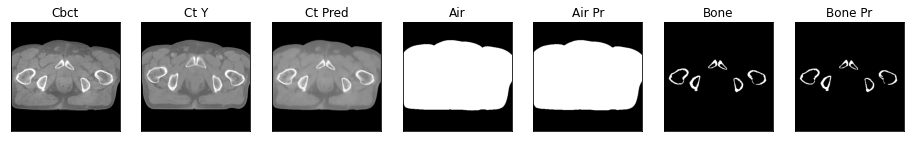

ssim score = 0.7672125697135925
psnr score = 21.36618423461914
snr score = 13.523354530334473
mae error = 0.03704795613884926
air dice score = 0.9992170610575523
bone dice score = 0.9444803934263688


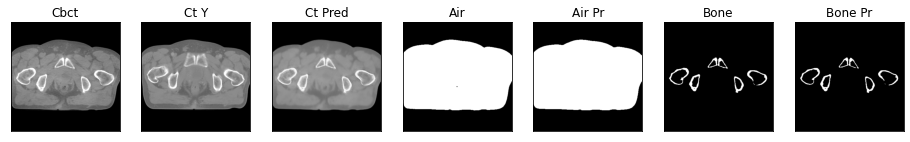

ssim score = 0.7544645667076111
psnr score = 21.25635528564453
snr score = 13.456307411193848
mae error = 0.038584645837545395
air dice score = 0.9991612595086383
bone dice score = 0.9374698213431014


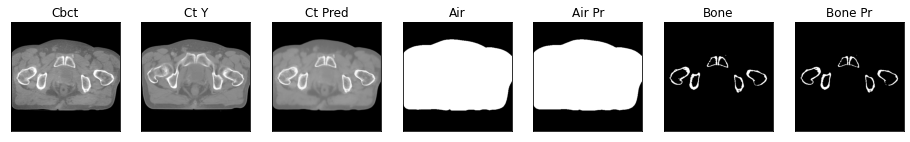

15it [00:33,  2.20s/it]

ssim score = 0.7514162063598633
psnr score = 21.237422943115234
snr score = 13.495711326599121
mae error = 0.03896521031856537
air dice score = 0.9991288692723159
bone dice score = 0.9352231203639108


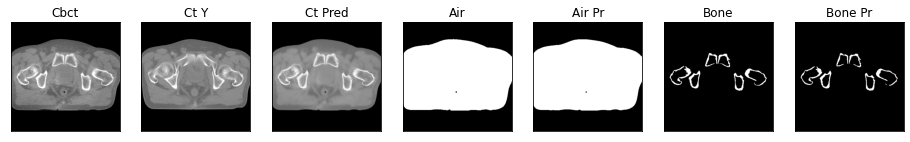

In [ ]:
test_epoch(model, testloader, device, True, os.path.join("eval-gan", wandb.run.name))

In [ ]:
discriminator = smp.Unet(encoder_name=ENCODER, encoder_weights=ENCODER_WEIGHT, in_channels=DIS_IN_CHANNELS, classes=DIS_N_CLASSES)
discriminator = Discriminator(encoder=discriminator.encoder, hidden_ch=2048, n_classes=DIS_N_CLASSES, activation=DIS_ACT)

In [ ]:
discriminator.load_state_dict(checkpoint["dicriminator"])

In [ ]:
# score_ssim_test, score_psnr_test, score_snr_test, score_mae_test, score_mask_test, score_acc_test 
eval_epoch(model, discriminator, testloader, device)